In [2]:
#creating and debugging threshold function
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
import nana

In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
#create a delta f (1/tmax-min aka 1/total observation time
#delta_f = 1/lc.time[-1] - lc.time[0] #this is in days
lc = lc_collection.stitch()
total_observation_time = lc.time[-1] - lc.time[0]
print(total_observation_time)
delta_f = (1/total_observation_time).value
print(delta_f)

1470.4622572100852
0.0006800582572566702


In [5]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)
print(f_min_no_units, f_max_no_units)

0.0006800582572566702
<class 'numpy.float64'>
0.0006800582572566702 48.93900034783809


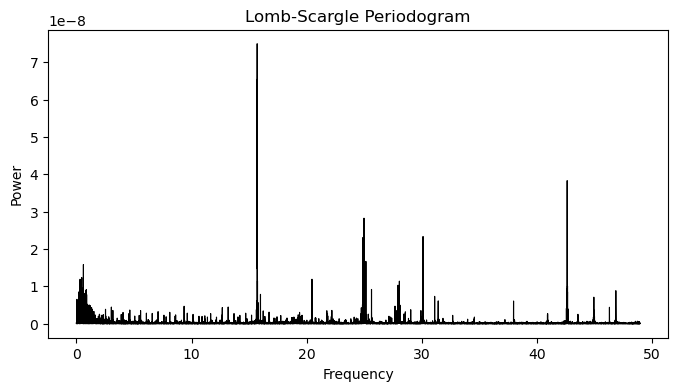

In [6]:
#trying to create periodograms of spacing 0.25*f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units, use this later in get_started function as x values
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units, use this later in get_started function as y values

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8) 
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()




In [7]:
indices = nana.get_started(100, freq_values, power_values)
print(indices)
print(len(indices))

[23088 23103 62667 36727 44265 36563 36970   904   690 30084   475 23129
 41244 41069 62709   714 62618 37686  1276 68880  1194   429   287   892
   524  1098 23510  1313  1289  1135 45748 66073  1241   538    81   821
   775 23062 46204 55821   857   344 23038 30101 23199  1181   728 36824
   940  1337   368 36536   303  1666  1490   489 41320 23152   565  1764
 40684 13759 62682 46189 19386  4473 62694  1604 68064 18640  1942 36386
  1168   764 36697 36673   441  1263 62570   403 23073   843   796 62757
 36761   502  2007  3726   750 66038 22990 42691 41259   675  6825 30122
  1408 32622   106  4664]
100


In [8]:
#take the each index of indices and look at the 
print(delta_f)

0.0006800582572566702


In [9]:
def threshold(indices, xs, ys):
    good_peaks = []
    peak_multiples = 0
    med_med = []
    for i in indices:
        leftside = ys[i-20:i]  
        rightside = ys[i+1:i+21]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        print("index:", i, "median:", median,"multiple:", ys[i]/median)
        peak_multiples += ys[i]/median
        med_med.append(ys[i]/median)
        if ys[i] > 5*median:
            good_peaks.append(i)
            print("good peak identified")
    print("average multiple = ",peak_multiples/len(indices))
    median_median = np.nanmedian(med_med)
    print("median multiple:", median_median)
    return np.array(good_peaks)

In [10]:
good_peaks = threshold(indices, freq_values, power_values)

index: 23088 median: 2.7753022990342184e-08 multiple: 2.702360862039056
index: 23103 median: 2.7753022990342184e-08 multiple: 2.35989367351569
index: 62667 median: 3.0708105363280476e-09 multiple: 12.481172779394742
good peak identified
index: 36727 median: 3.420997963370004e-09 multiple: 8.26163912971087
good peak identified
index: 44265 median: 2.361227174615845e-09 multiple: 9.893995436107181
good peak identified
index: 36563 median: 1.6144225373909467e-09 multiple: 14.273743573914896
good peak identified
index: 36970 median: 1.474020750384962e-09 multiple: 11.326547004901114
good peak identified
index: 904 median: 5.381831515232017e-09 multiple: 2.944265705018436
index: 690 median: 2.6291483217193414e-09 multiple: 4.70312382488823
index: 30084 median: 3.276794555096254e-09 multiple: 3.6362478916200422
index: 475 median: 2.083897554343373e-09 multiple: 5.714483712389952
good peak identified
index: 23129 median: 2.5613569398072437e-09 multiple: 4.47469083418496
index: 41244 median: 2

In [11]:
print(good_peaks)
print(len(good_peaks))

[62667 36727 44265 36563 36970   475 41244 41069 62709 62618 37686 23510
  1135 45748 66073 55821 23199   940 40684 13759 19386  4473  1604 68064
 18640 36386 62570 62757 22990 42691  6825  1408 32622  4664]
34


In [12]:
#62667
peak = power_values[62667]
print("peak:", peak)
leftside = power_values[62667-20:62667]  
rightside = power_values[62667+1:62667+21]
print("leftside:", leftside)
print("rightside:", rightside)
median = np.nanmedian(np.concatenate((leftside,rightside)))
print("median:", median)
        #print("median:", median, ys[i]/median)

peak: 3.83273168766962e-08
leftside: [2.37242016e-10 5.50483259e-10 9.22782678e-10 1.24600598e-09
 1.41023751e-09 1.34288732e-09 1.04633947e-09 6.23553623e-10
 2.82503447e-10 3.14264747e-10 1.04530061e-09 2.77086968e-09
 5.68203302e-09 9.80198308e-09 1.49472785e-08 2.07256884e-08
 2.65753127e-08 3.18409132e-08 3.58749994e-08 3.81451994e-08]
rightside: [3.63657322e-08 3.24889154e-08 2.71763730e-08 2.10825611e-08
 1.49313805e-08 9.40038920e-09 5.01586675e-09 2.07790252e-09
 6.28954488e-10 4.70737377e-10 1.22449742e-09 2.42086924e-09
 3.59971368e-09 4.39903611e-09 4.61551793e-09 4.22632291e-09
 3.37075139e-09 2.29886140e-09 1.30056755e-09 6.31867413e-10]
median: 3.0708105363280476e-09


In [13]:
#62667
peak = power_values[62667]
print("peak:", peak)
leftside = power_values[62667-10:62667]  
rightside = power_values[62667+1:62667+11]
print("leftside:", leftside)
print("rightside:", rightside)
median = np.nanmedian(np.concatenate((leftside,rightside)))
print("median:", median)
        #print("median:", median, ys[i]/median)

peak: 3.83273168766962e-08
leftside: [1.04530061e-09 2.77086968e-09 5.68203302e-09 9.80198308e-09
 1.49472785e-08 2.07256884e-08 2.65753127e-08 3.18409132e-08
 3.58749994e-08 3.81451994e-08]
rightside: [3.63657322e-08 3.24889154e-08 2.71763730e-08 2.10825611e-08
 1.49313805e-08 9.40038920e-09 5.01586675e-09 2.07790252e-09
 6.28954488e-10 4.70737377e-10]
median: 1.493932949647538e-08


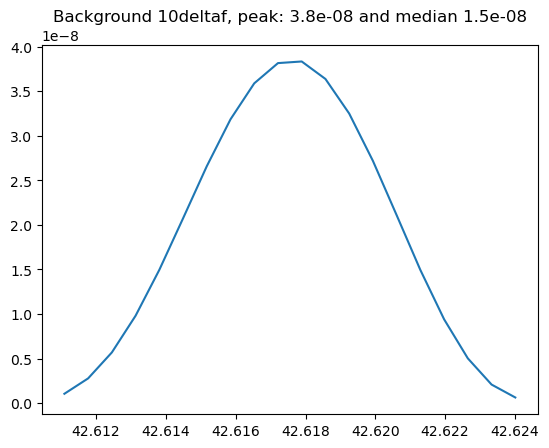

In [14]:
plt.title("Background 10deltaf, peak: 3.8e-08 and median 1.5e-08")
plt.plot(freq_values[62667-10:62667+10], power_values[62667-10:62667+10])

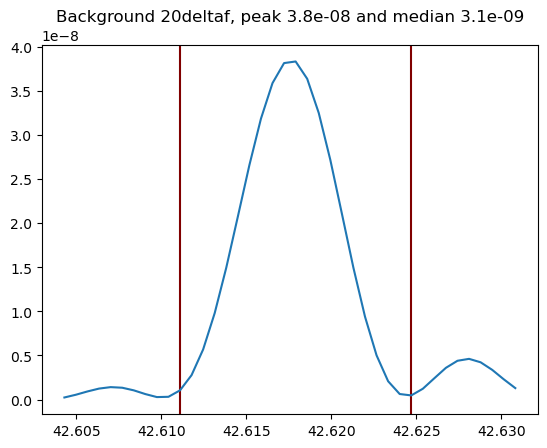

In [15]:
plt.title("Background 20deltaf, peak 3.8e-08 and median 3.1e-09")
plt.axvline(x = freq_values[62667-10], color = 'maroon')
plt.axvline(x = freq_values[62667+10], color = 'maroon')
plt.plot(freq_values[62667-20:62667+20], power_values[62667-20:62667+20])

In [16]:
print(delta_f)

0.0006800582572566702


In [17]:
freq_values[100]-freq_values[99]

0.0006800582572566716

In [18]:
#top 10 peak indices
topten =  nana.get_started(10, freq_values, power_values)
print(topten)

[23088 23103 62667 36727 44265 36563 36970   904   690 30084]


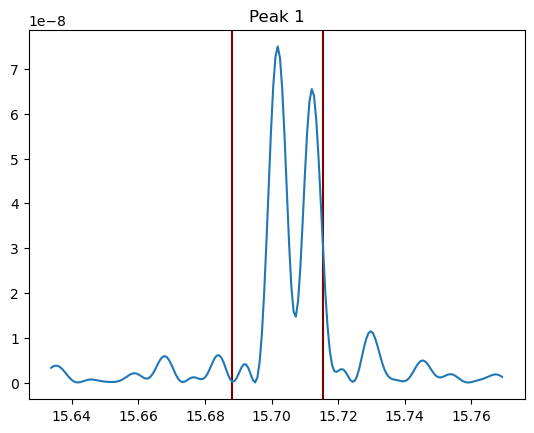

In [19]:
plt.title("Peak 1")
plt.axvline(x = freq_values[23088-20], color = 'maroon')
plt.axvline(x = freq_values[23088+20], color = 'maroon')
plt.plot(freq_values[23088-100:23088+100], power_values[23088-100:23088+100])

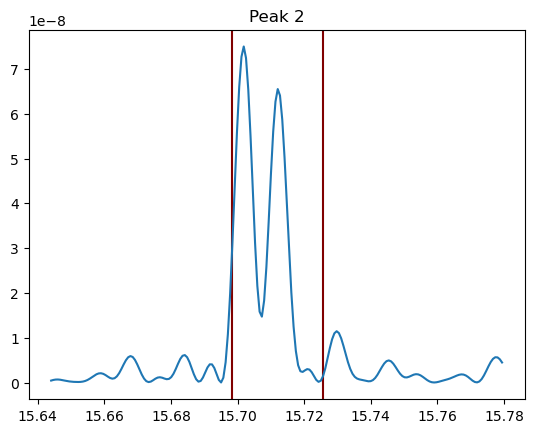

In [20]:
plt.title("Peak 2")
plt.axvline(x = freq_values[23103-20], color = 'maroon')
plt.axvline(x = freq_values[23103+20], color = 'maroon')
plt.plot(freq_values[23103-100:23103+100], power_values[23103-100:23103+100])

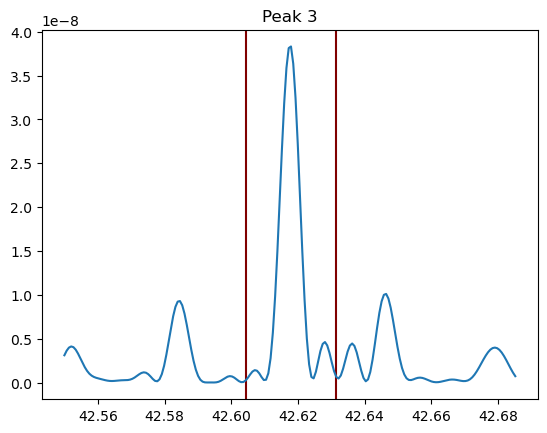

In [21]:
plt.title("Peak 3")
plt.axvline(x = freq_values[62667-20], color = 'maroon')
plt.axvline(x = freq_values[62667+20], color = 'maroon')
plt.plot(freq_values[62667-100:62667+100], power_values[62667-100:62667+100])

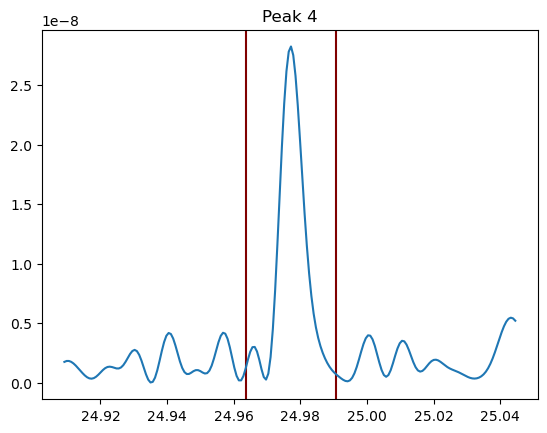

In [22]:
plt.title("Peak 4")
plt.axvline(x = freq_values[36727-20], color = 'maroon')
plt.axvline(x = freq_values[36727+20], color = 'maroon')
plt.plot(freq_values[36727-100:36727+100], power_values[36727-100:36727+100])

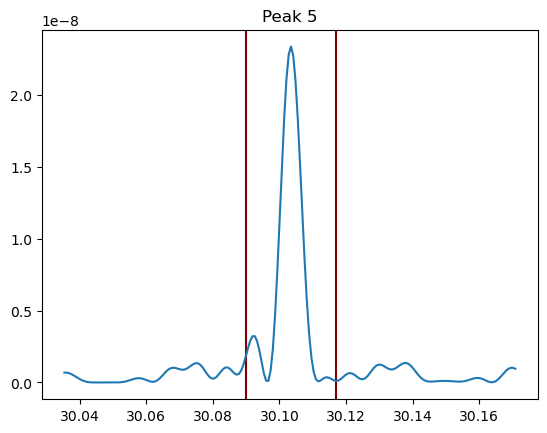

In [23]:
plt.title("Peak 5")
plt.axvline(x = freq_values[44265-20], color = 'maroon')
plt.axvline(x = freq_values[44265+20], color = 'maroon')
plt.plot(freq_values[44265-100:44265+100], power_values[44265-100:44265+100])

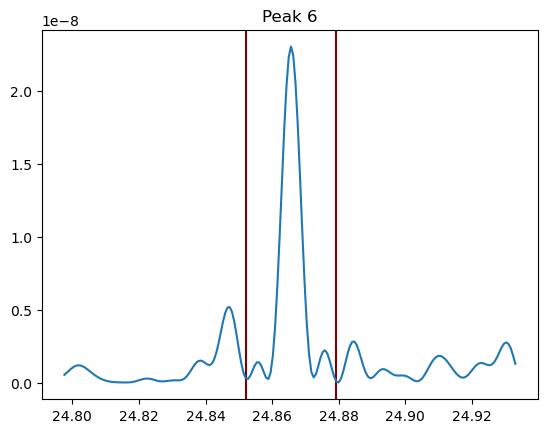

In [24]:
plt.title("Peak 6")
plt.axvline(x = freq_values[36563-20], color = 'maroon')
plt.axvline(x = freq_values[36563+20], color = 'maroon')
plt.plot(freq_values[36563-100:36563+100], power_values[36563-100:36563+100])

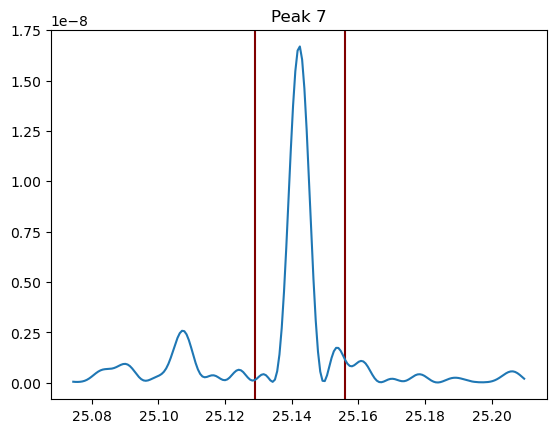

In [25]:
plt.title("Peak 7")
plt.axvline(x = freq_values[36970-20], color = 'maroon')
plt.axvline(x = freq_values[36970+20], color = 'maroon')
plt.plot(freq_values[36970-100:36970+100], power_values[36970-100:36970+100])


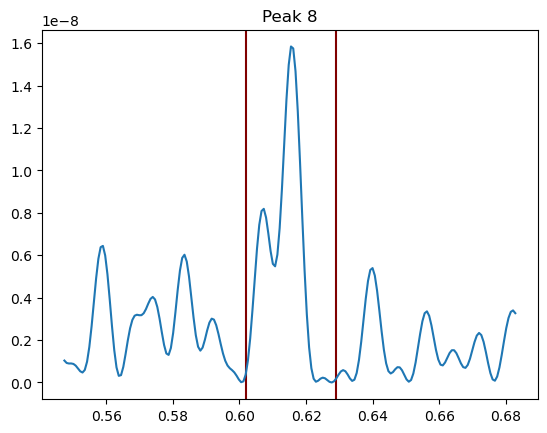

In [26]:
plt.title("Peak 8")
plt.axvline(x = freq_values[904-20], color = 'maroon')
plt.axvline(x = freq_values[904+20], color = 'maroon')
plt.plot(freq_values[904-100:904+100], power_values[904-100:904+100])


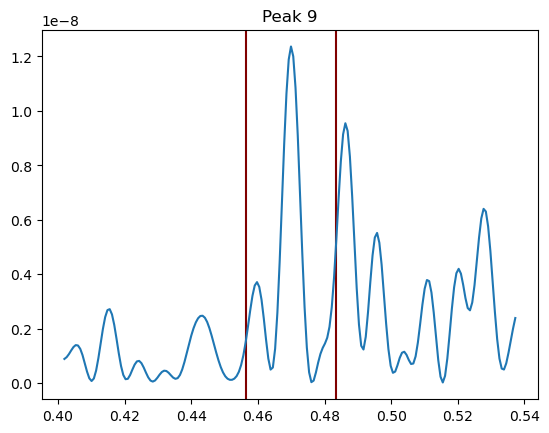

In [27]:
plt.title("Peak 9")
plt.axvline(x = freq_values[690-20], color = 'maroon')
plt.axvline(x = freq_values[690+20], color = 'maroon')
plt.plot(freq_values[690-100:690+100], power_values[690-100:690+100])


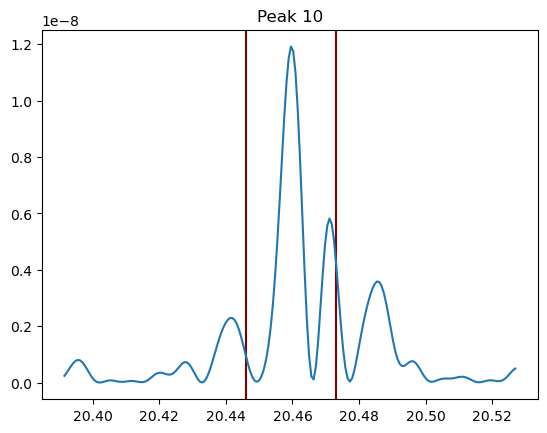

In [28]:
plt.title("Peak 10")
plt.axvline(x = freq_values[30084-20], color = 'maroon')
plt.axvline(x = freq_values[30084+20], color = 'maroon')
plt.plot(freq_values[30084-100:30084+100], power_values[30084-100:30084+100])


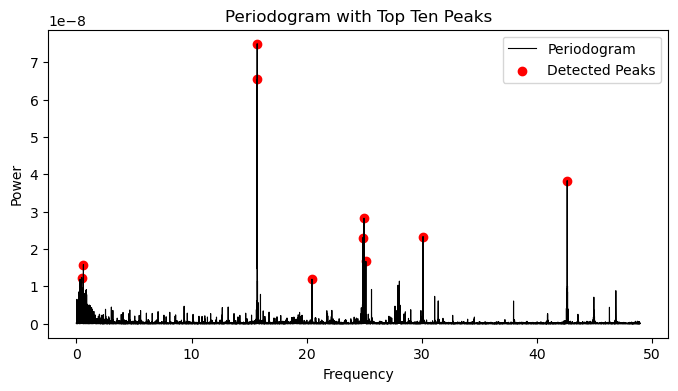

In [29]:
#marking the refined peaks that we found

plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(freq_values[topten], power_values[topten], color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Periodogram with Top Ten Peaks")
plt.legend()

plt.show()


In [30]:
#ratio of  d2y/dx2 at peak) / (y_peak)
#I'm expecting ratio sof 10^6, but we're getting 10^5 so the ratios of off for some reason.
#this suggests that my peaks are too wide? --> this is why hogg thinks my freuqnecy resolution is too small
#even though it's not

xs_refined, ys_refined, second_derivative = nana.refine_peaks(freq_values, power_values, topten)
ratio = (second_derivative/ys_refined)
print("this is ratio of (d2y/dx2 at peak) / (y_peak):", ratio)

this is ratio of (d2y/dx2 at peak) / (y_peak): [-139978.92937889 -140272.71285293 -120358.46591736  -89334.1265266
 -111559.01895282 -127563.83997935 -110404.33429943 -130893.91996791
 -147102.26829462 -104471.11738372]


In [31]:
print(freq_values[1]-freq_values[0])
print(delta_f)
print(second_derivative)

0.0006800582572566702
0.0006800582572566702
[-0.01049853 -0.00919472 -0.00463524 -0.00252564 -0.00260631 -0.00293977
 -0.0018465  -0.00208434 -0.00181926 -0.00124611]


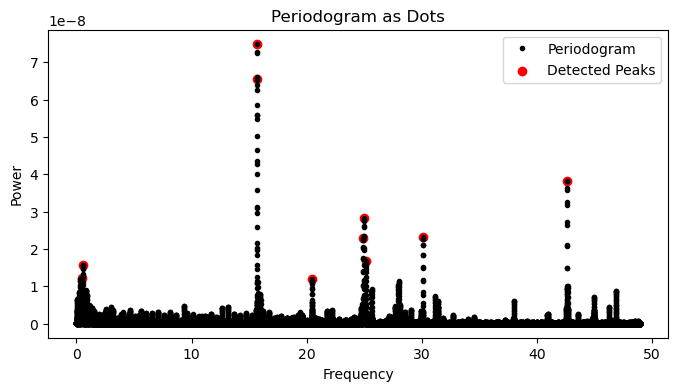

In [32]:
#plt.plot(x, y, "k.")
plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k.',label="Periodogram")

plt.scatter(freq_values[topten], power_values[topten], color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Periodogram as Dots")
plt.legend()

plt.show()


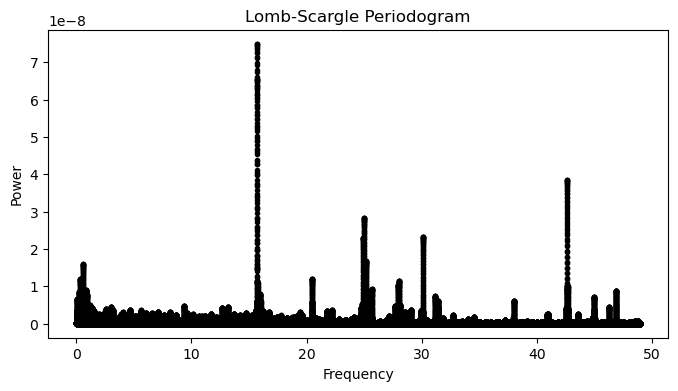

In [33]:
#periodogram and frequency values with increments 0.25deltaf
#trying to create periodograms of spacing 0.25*f_min

frequency_grid2 = np.arange(f_min_no_units, f_max_no_units, delta_f/4) #spacing with increments of f_min/4, starting with f_min_no_units to avoid di

pg_quarter = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid2  # Unitless frequency grid
)

freq3_values = np.array(pg_quarter.frequency.value)  
power3_values = np.array(pg_quarter.power.value)  

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq3_values, power3_values, 'k.', lw=0.8) 
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()


In [97]:
##checking ratio for smaller frequency resolution (delta_f*0.25)
##CONCLUSION: I think that the sampling by fmin is actually oversampling the periodogram
#when I made the frequency resolution even more fine the second derivative went down instead of up
#which is not what we're expecting
topten2 =  nana.get_started(10, freq3_values, power3_values)
xs_refined2, ys_refined2, second_derivative2 = nana.refine_peaks(freq3_values, power3_values, topten)
ratio2 = (second_derivative2/ys_refined2)
print("this is ratio for smaller frequency resolution:", ratio2)
print("this is the original ratio:,", ratio)
print(ratio3)
print("this is original second derivative:", second_derivative, "this is oversampled second derivative:", second_derivative2)

this is ratio for smaller frequency resolution: [  -77800.77008893  -135544.35784785  2758411.48347954   122066.37322957
   -29835.71484847   -18368.68568295 -1516629.80583215   -12258.33767825
   -83132.67396108  -157218.67490788]
this is the original ratio:, [-139978.92937889 -140272.71285293 -120358.46591736  -89334.1265266
 -111559.01895282 -127563.83997935 -110404.33429943 -130893.91996791
 -147102.26829462 -104471.11738372]
[  -249.49706608   -442.88928405   3489.77514416   1086.99533082
   -148.87138286   -133.08846312   1828.8065378   -2021.16721744
 -19694.442005    -6210.49744389]
this is original second derivative: [-0.01049853 -0.00919472 -0.00463524 -0.00252564 -0.00260631 -0.00293977
 -0.0018465  -0.00208434 -0.00181926 -0.00124611] this is oversampled second derivative: [-1.87119514e-05 -2.90229279e-05  1.34382375e-04  3.07251050e-05
 -3.47792891e-06 -3.06687102e-06  3.05873420e-05 -3.21863334e-05
 -2.43525913e-04 -7.40882564e-05]


In [34]:
#im checking here that the frequency resolution is what I'm expecting
print(freq3_values[1] - freq3_values[0])
print(delta_f/4)
#print(f_min_no_units)

0.00017001456431416757
0.00017001456431416754


In [35]:
#fs is the sampl
#uncertainty principle for period finding?
fs = 1/delta_f #fs is sampling freuqency in hertz
ts = np.arange(0,10,1/fs)

ys = 1 + 0.01 * np.cos(2 * np.pi * ts)
print(ys)

[1.01       1.00999991 1.00999963 ... 1.00999937 1.00999976 1.00999996]


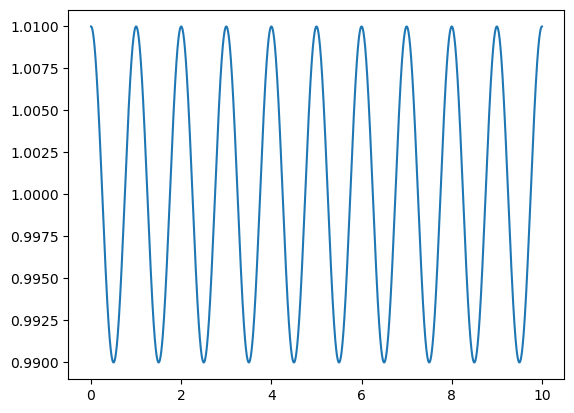

In [36]:
plt.plot(ts,ys)

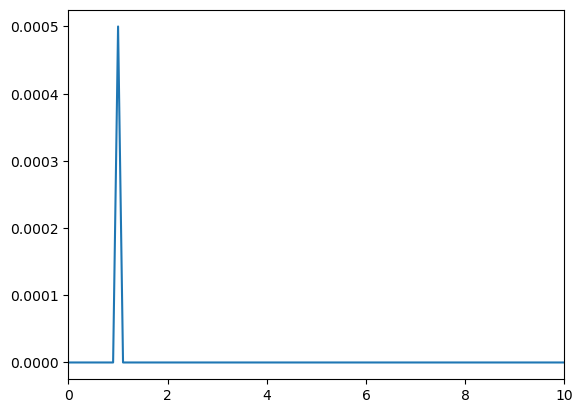

In [37]:

freq, power = scipy.signal.periodogram(ys,fs)

plt.xlim([0,10])
plt.plot(freq,power)


[1.01       1.00999991 1.00999963 ... 1.00999937 1.00999976 1.00999996]


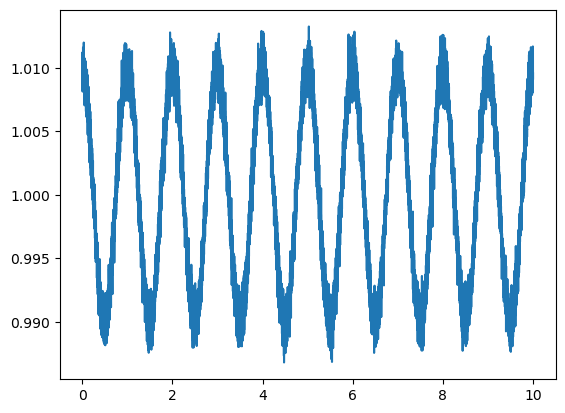

In [99]:
#with noise
fs = 1/delta_f #fs is sampling freuqency in hertz
ts_noise = np.arange(0,10,1/fs)

ys_noise = 1 + 0.01 * np.cos(2 * np.pi * ts) + 0.001 * np.random.normal(size=ts.shape)
print(ys)

plt.plot(ts_noise,ys_noise)

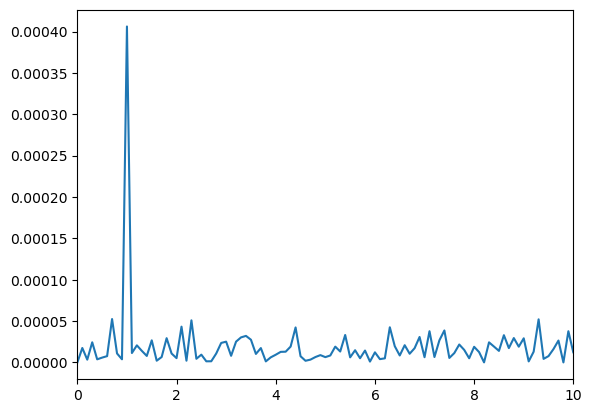

In [39]:
freq_noise, power_noise = scipy.signal.periodogram(ys_noise,fs)
plt.xlim([0,10])
plt.plot(freq_noise,power_noise)

In [40]:
peaks_fake = nana.get_started(1,freq_noise,power_noise)
print(peaks_fake)
print(freq_noise[peaks_fake])

[10]
[0.99997433]


In [41]:
refine = nana.refine_peaks(freq_noise,power_noise,peaks_fake)
print(refine)

(array([1.00044965]), array([0.00040614]), array([-0.07970345]))


In [42]:
print("these are the x values:", "left:", freq_noise[9], "middle:", freq_noise[10], "right:", freq_noise[11])
print("these are the y values:", 
"left:", power_noise[9], "middle:", power_noise[10], "right:", power_noise[11])


these are the x values: left: 0.8999769000265737 middle: 0.9999743333628597 right: 1.0999717666991455
these are the y values: left: 3.84351046671904e-06 middle: 0.0004061286409255656 right: 1.1420187581032237e-05


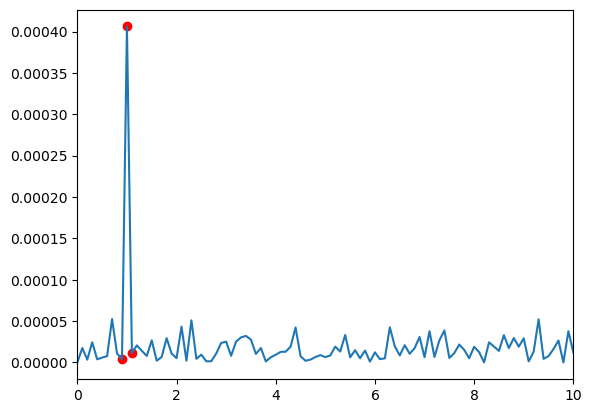

In [43]:
plt.xlim([0,10])
plt.scatter(freq_noise[9:12], power_noise[9:12], color='red', marker='o')
plt.plot(freq_noise,power_noise)